In [1]:
from process_data import clean_data, create_index, pivot_data, clean_data2
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.models import load_model
import matplotlib.pyplot as plt
import time
import datetime
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

Using TensorFlow backend.


In [34]:
def data_lstm(X,y,lookback=1):
    newX = []
    newY = []
    for i in range(len(y)-lookback):
        newX.append(X[i:i+1+lookback,:])
        newY.append(y[i+lookback])
    return np.array(newX), np.array(newY)


def create_rnn(lookback,num_features):
    model = Sequential()
    model.add(LSTM(return_sequences=True, batch_input_shape=(24,lookback+1,num_features), units=16, stateful=True))
    #model.add(Dropout(0.05))

    model.add(LSTM(units=8,return_sequences=True, stateful=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=4,stateful=True))
    #model.add(Dropout(0.05))
    
    model.add(Dense(units=1))
    model.add(Activation('linear'))

    start = time.time()
    model.compile(loss='mse', optimizer='adadelta')
    print('compilation time : {}'.format(time.time() - start))
    print(model.summary())
    return model


def train_rnn(df,date_predict,lookback,epochs=100):
    #Preparting data to Train
    #print('Preparing data to Train')
    date_p = datetime.datetime.strptime(date_predict, "%Y-%m-%d").date()
    date_limit = (date_p - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
    date_start = (date_p - datetime.timedelta(days=40+lookback//24)).strftime('%Y-%m-%d')
    sk = df[:date_limit].copy()
    print(sk.shape)
    sk = sk.drop(['TRADEDATE', 'RTENERGY'], axis=1)

    #sk.hourofday = sk.hourofday.dt.seconds/3600
    sk = sk[date_start:]
    print(sk.shape)
    y = sk.pop('DAENERGY').values
    X = sk.values[:,1:]
    X,y = data_lstm(X,y,lookback)
    print(X.shape)
    model = create_rnn_2(lookback,X.shape[2])

    #X = X.reshape(X.shape[0],X.shape[1],1)
    filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
    filepath="best_model_lstm_new.hdf5"

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
    tensorboard = TensorBoard(log_dir='./logs/'+str(time.time()), 
                              histogram_freq=0, 
                              batch_size=24, 
                              write_graph=True, 
                              write_grads=False, 
                              write_images=True, 
                              )
    # #Training Model
    model.fit(
        X,
        y,
        batch_size=24,  #168, 
        epochs=epochs,
        shuffle = False,
        validation_split=0.043, callbacks=[tensorboard, checkpoint, early_stop])  #0.0857 #0.05 #0.1

    #preparing data to Predict
    return model, X, y

def predict_day(date_predict,model,lookback=168):
    date_p = datetime.datetime.strptime(date_predict, "%Y-%m-%d").date()
    date_limit = (date_p - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
    date_start = (date_p - datetime.timedelta(days=42)).strftime('%Y-%m-%d')

    df_predict = df.copy()
    df_predict = df_predict[:date_predict]

    df_predict = df_predict.drop(['TRADEDATE', 'RTENERGY'], axis=1)

    #df_predict.hourofday = df_predict.hourofday.dt.seconds/3600
    df_predict = df_predict[date_start:]
    y = df_predict.pop('DAENERGY').values
    X = df_predict.values[:,1:]
    X,y = data_lstm(X,y,lookback)

    input_p = X[-24:]   #-24
    pred = model.predict(input_p,batch_size=24)

    results = df[date_predict].copy()
    # pred_ada = model.predict(input_p.values)
    results['forecast'] = pred
    RMSE = get_rmse(results['DAENERGY'].values, pred)
    return results, RMSE

def plot_results(results,date_predict):
    RMSE = get_rmse(results['DAENERGY'], results['forecast'])
    fig, ax = plt.subplots(figsize=(9,4))
    # npre = 24
    ax.set(title='DAENERGY '+ 'RMSE: {:.3f} for {}'.format(RMSE, date_predict), xlabel='Date', ylabel='Price DAENERGY')
    #
    # # Plot data points
    results['DAENERGY'].plot(ax=ax, style='o', label='Observed')
    #
    # # Plot predictions
    results.forecast.plot(ax=ax, style='r--', label='forecast')
    # #ci = predict_ci.loc[date_predict]
    # #ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
    legend = ax.legend(loc='lower right')


def get_rmse(pred,real):
    return np.sqrt(((pred-real)**2).sum()/pred.shape[0])

def create_date_range(start_date, end_date):
    start_dt = datetime.datetime.strptime(start_date, "%Y-%m-%d").date()
    end_dt = datetime.datetime.strptime(end_date, "%Y-%m-%d").date()
    dates = []
    cur_dt = start_dt
    dates.append(start_date)
    while cur_dt<end_dt:
        cur_dt = cur_dt + datetime.timedelta(days=1)
        dates.append(cur_dt.strftime('%Y-%m-%d'))
    return dates


def create_features(df):
    df = df.copy()
    features = ['Ph-1', 'Ph-2', 'Ph-3', 'Ph-24', 'Ph-25', 'Ph-48', 'Ph-49',
                'Ph-72','Ph-73', 'Ph-96', 'Ph-97', 'Ph-120', 'Ph-121', 'Ph-144',
                'Ph-145', 'Ph-168']
    deltas = [1, 2, 3, 24, 25, 48, 49, 72, 73, 96, 97, 120, 121, 144, 145, 168]

    for col, shift in zip(features, deltas):
        df[col] = df.DAENERGY.shift(shift)
    return df

def create_rollings(df):
    df = df.copy()
    means_cols = ['mean_3','mean_6','mean_9','mean_12','mean_24']
    means_values = [3,6,9,12,24]
    
    for col, val in zip(means_cols, means_values):
        df[col] = pd.Series.rolling(df.DAENERGY, window=val, center = False).mean()
        df[col] = df[col].shift(24)
    
    #df['p_1'] = df.DAENERGY.shift(1)
    df['p_24'] = df.DAENERGY.shift(24)
    df['p_48'] = df.DAENERGY.shift(48)
    return df        

def MAPE(y_true, y_pred):
    return 1.0/len(y_true)*(np.abs((y_true-y_pred))/y_true*100).sum()

from keras.optimizers import RMSprop, Adam, Adadelta

def create_rnn_2(lookback, num_features):
    model = Sequential()
    model.add(LSTM(return_sequences=True, batch_input_shape=(24,lookback+1,num_features), units=20, stateful=False))
    model.add(Dropout(0.5))

    model.add(LSTM(units=20,return_sequences=False, stateful=False))
    model.add(Dropout(0.5))
    
    #model.add(LSTM(units=20,stateful=False))
    #model.add(Dropout(0.5))
    
    model.add(Dense(units=10))
    model.add(Activation('linear'))

    model.add(Dense(units=1))
    model.add(Activation('linear'))

    #optim = RMSprop(lr=0.01)
    #optim = Adadelta()
    start = time.time()
    model.compile(loss='mse', optimizer = 'adadelta')
    print('compilation time : {}'.format(time.time() - start))
    print(model.summary())
    return model

def create_nn(lookback, num_features):
    model = Sequential()
    model.add(LSTM(return_sequences=True, batch_input_shape=(24,lookback+1,num_features), units=20, stateful=False))
    model.add(Dropout(0.5))

    model.add(LSTM(units=20,return_sequences=False, stateful=False))
    model.add(Dropout(0.5))
    
    #model.add(LSTM(units=20,stateful=False))
    #model.add(Dropout(0.5))
    
    model.add(Dense(units=10))
    model.add(Activation('linear'))

    model.add(Dense(units=1))
    model.add(Activation('linear'))

    #optim = RMSprop(lr=0.01)
    #optim = Adadelta()
    start = time.time()
    model.compile(loss='mse', optimizer = 'adadelta')
    print('compilation time : {}'.format(time.time() - start))
    print(model.summary())
    return model

In [35]:
df = pivot_data('../data/Data.txt')
#scaler = MinMaxScaler(feature_range=(-1,1)).fit(df.DAENERGY)
#df.DAENERGY = scaler.transform(df.DAENERGY)
df = clean_data(df)
df = create_index(df)
df2 = pivot_data('../data/FurtherBack.txt','2017-05-15','2017-07-07')
df2 = clean_data2(df2)
df2 = create_index(df2)
df = pd.concat([df,df2])

df = create_rollings(df)
df = df.dropna()
list_scalers = dict()
for c in df.columns.values:
    list_scalers[c] = MinMaxScaler()
    list_scalers[c].fit(df[c].values.reshape(-1,1))
    df[c] = list_scalers[c].transform(df[c].values.reshape(-1,1))
print('Training the model...')

lookback=72#48#168

Training the model...


In [36]:
#df.DAENERGY = list_scalers['DAENERGY'].inverse_transform(df.DAENERGY.values)
model, X, y = train_rnn(df,'2017-10-01',lookback=lookback,epochs=20)

(3335, 150)
(2304, 148)
(2232, 73, 146)
compilation time : 0.00764989852905
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (24, 73, 20)              13360     
_________________________________________________________________
dropout_9 (Dropout)          (24, 73, 20)              0         
_________________________________________________________________
lstm_10 (LSTM)               (24, 20)                  3280      
_________________________________________________________________
dropout_10 (Dropout)         (24, 20)                  0         
_________________________________________________________________
dense_9 (Dense)              (24, 10)                  210       
_________________________________________________________________
activation_9 (Activation)    (24, 10)                  0         
_________________________________________________________________


In [37]:
model = load_model('best_model_lstm_new.hdf5')

In [38]:
%matplotlib inline

MAPE mean:17.94


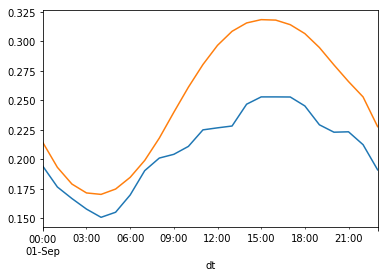

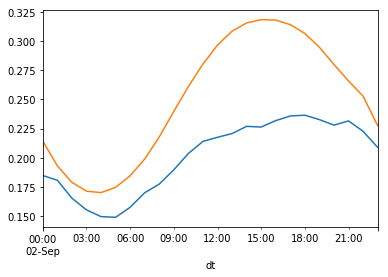

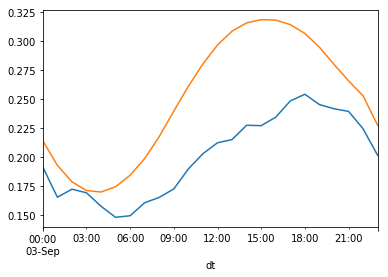

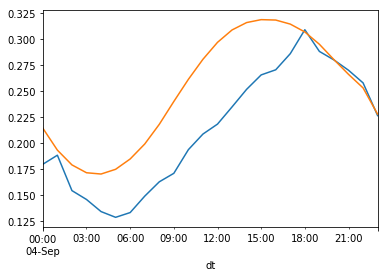

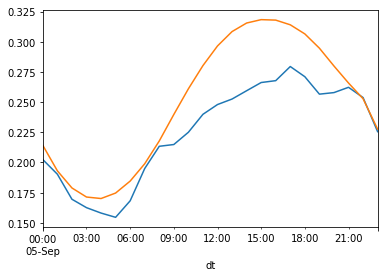

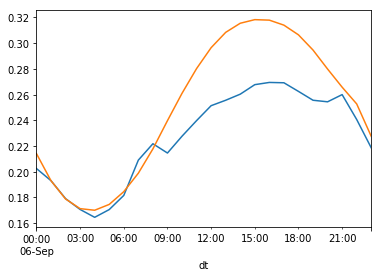

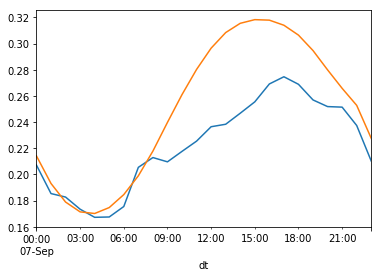

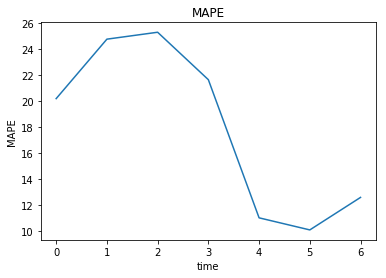

In [39]:
MAPEs = []
for day in create_date_range('2017-09-01','2017-09-07'):
    results, rmse = predict_day(day,model,lookback)
    plt.figure()
    results.DAENERGY.plot()
    results.forecast.plot()
    y_pred = list_scalers['DAENERGY'].inverse_transform(results.forecast.values.reshape(-1,1))
    y_true = list_scalers['DAENERGY'].inverse_transform(results.DAENERGY.values.reshape(-1,1))
    MAPEs.append(MAPE(y_true, y_pred))
plt.figure()
plt.plot(MAPEs)
plt.title('MAPE')
plt.xlabel('time')
plt.ylabel('MAPE')
print('MAPE mean:{:.2f}'.format(np.array(MAPEs).mean()))

MAPE mean:15.21


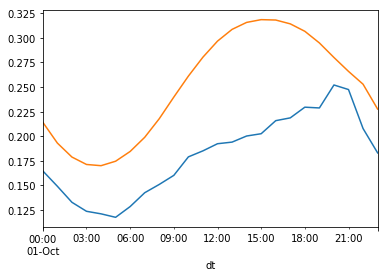

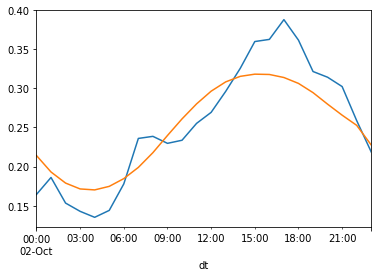

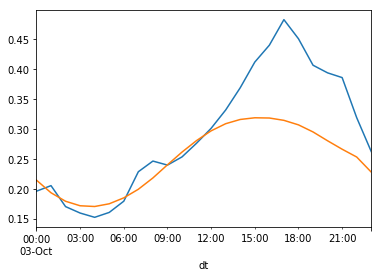

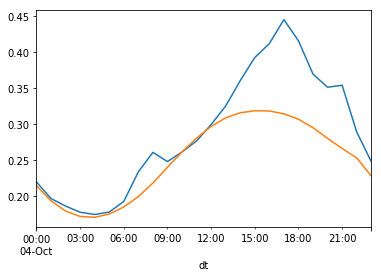

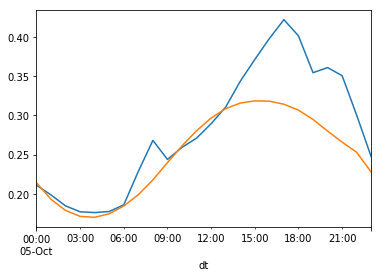

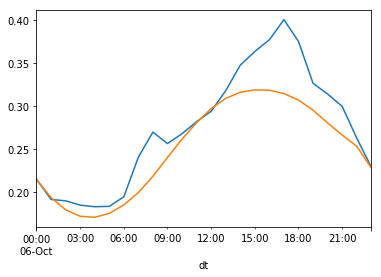

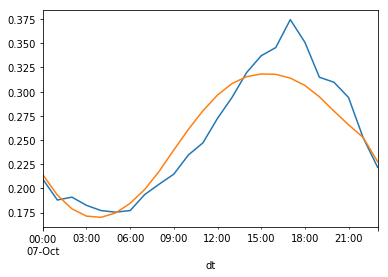

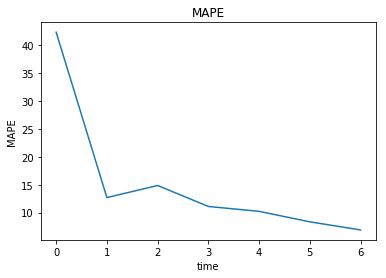

In [40]:
MAPEs=[]
for day in create_date_range('2017-10-01','2017-10-07'):
    results, rmse = predict_day(day,model,lookback)
    plt.figure()
    results.DAENERGY.plot()
    results.forecast.plot()
    y_pred = list_scalers['DAENERGY'].inverse_transform(results.forecast.values.reshape(-1,1))
    y_true = list_scalers['DAENERGY'].inverse_transform(results.DAENERGY.values.reshape(-1,1))
    MAPEs.append(MAPE(y_true, y_pred))
plt.figure()
plt.plot(MAPEs)
plt.title('MAPE')
plt.xlabel('time')
plt.ylabel('MAPE')
print('MAPE mean:{:.2f}'.format(np.array(MAPEs).mean()))

MAPE mean:36.28


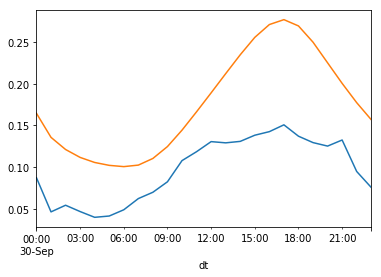

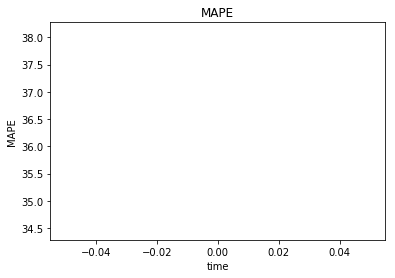

In [60]:
MAPEs=[]
day ='2017-09-30'
results, rmse = predict_day(day,model,lookback)
plt.figure()
results.DAENERGY.plot()
results.forecast.plot()
y_pred = list_scalers['DAENERGY'].inverse_transform(results.forecast.values.reshape(-1,1))
y_true = list_scalers['DAENERGY'].inverse_transform(results.DAENERGY.values.reshape(-1,1))
MAPEs.append(MAPE(y_true, y_pred))
plt.figure()
plt.plot(MAPEs)
plt.title('MAPE')
plt.xlabel('time')
plt.ylabel('MAPE')
print('MAPE mean:{:.2f}'.format(np.array(MAPEs).mean()))

- MAPES:

|Model |MAPE Sept|MAPE Oct|
|:-----|:--------|:-------|
|lookback 48|25.1|22.54|
|| |27.12|

Epoch 10/25
888/912 [============================>.] - ETA: 0s - loss: 0.0046Epoch 00009: val_loss did not improve
912/912 [==============================] - 11s - loss: 0.0046 - val_loss: 0.0078

Epoch 10/10
888/912 [============================>.] - ETA: 0s - loss: 0.0046Epoch 00009: val_loss did not improve
912/912 [==============================] - 2s - loss: 0.0047 - val_loss: 0.0230
Epoch 10/10
888/912 [============================>.] - ETA: 0s - loss: 0.0038Epoch 00009: val_loss did not improve
912/912 [==============================] - 4s - loss: 0.0037 - val_loss: 0.0032   16.82

In [77]:
model, X, y = train_rnn(df,'2017-10-01',lookback=lookback,epochs=500)


(2063, 150)
(1008, 148)
(960, 49, 146)
compilation time : 0.00779509544373
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (24, 49, 16)              10432     
_________________________________________________________________
lstm_32 (LSTM)               (24, 49, 8)               800       
_________________________________________________________________
lstm_33 (LSTM)               (24, 4)                   208       
_________________________________________________________________
dense_11 (Dense)             (24, 1)                   5         
_________________________________________________________________
activation_11 (Activation)   (24, 1)                   0         
Total params: 11,445
Trainable params: 11,445
Non-trainable params: 0
_________________________________________________________________
None
Train on 912 samples, validate on 48 samples
Epoch 1/500
9

912/912 [==============================] - 3s - loss: 0.0015 - val_loss: 0.0039
Epoch 77/500
912/912 [==============================] - 3s - loss: 0.0014 - val_loss: 0.0040
Epoch 78/500
912/912 [==============================] - 3s - loss: 0.0014 - val_loss: 0.0041
Epoch 79/500
912/912 [==============================] - 3s - loss: 0.0014 - val_loss: 0.0042
Epoch 80/500
912/912 [==============================] - 3s - loss: 0.0014 - val_loss: 0.0042
Epoch 81/500
912/912 [==============================] - 3s - loss: 0.0014 - val_loss: 0.0044
Epoch 82/500
912/912 [==============================] - 3s - loss: 0.0014 - val_loss: 0.0044
Epoch 83/500
912/912 [==============================] - 3s - loss: 0.0013 - val_loss: 0.0044
Epoch 84/500
912/912 [==============================] - 3s - loss: 0.0013 - val_loss: 0.0044
Epoch 85/500
912/912 [==============================] - 3s - loss: 0.0013 - val_loss: 0.0044
Epoch 86/500
912/912 [==============================] - 3s - loss: 0.0013 - val_los

KeyboardInterrupt: 

In [51]:
model = load_model('best_model_lstm_new.hdf5')

MAPE mean:6.03


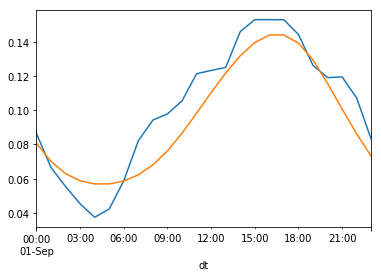

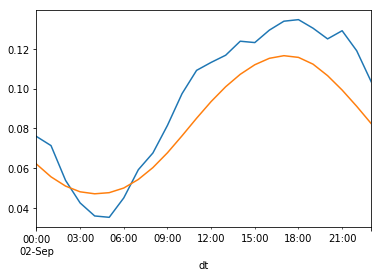

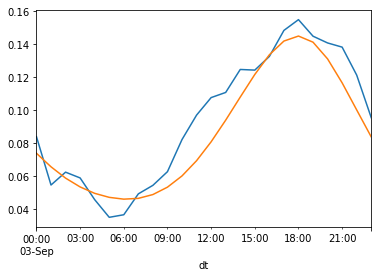

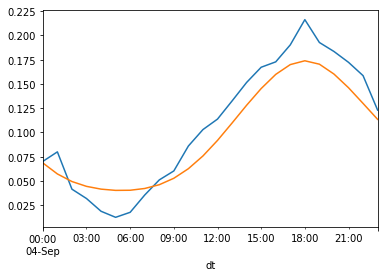

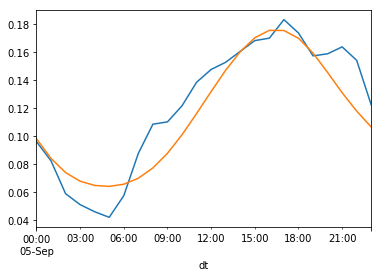

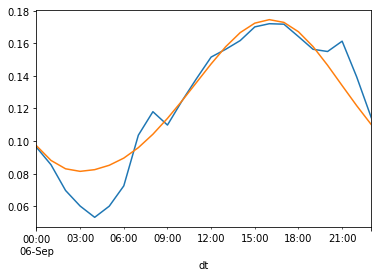

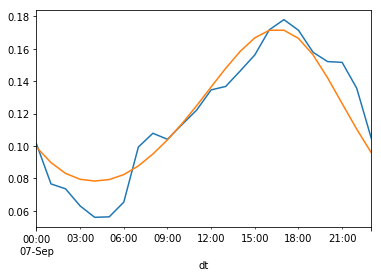

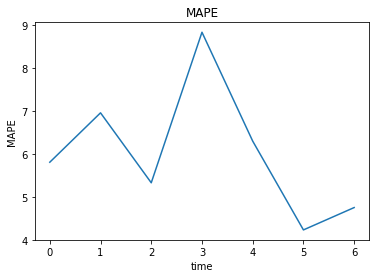

In [21]:
%matplotlib inline
MAPEs = []
for day in create_date_range('2017-09-01','2017-09-07'):
    results, rmse = predict_day(day,model,lookback)
    plt.figure()
    results.DAENERGY.plot()
    results.forecast.plot()
    y_pred = list_scalers['DAENERGY'].inverse_transform(results.forecast.values.reshape(-1,1))
    y_true = list_scalers['DAENERGY'].inverse_transform(results.DAENERGY.values.reshape(-1,1))
    MAPEs.append(MAPE(y_true, y_pred))
plt.figure()
plt.plot(MAPEs)
plt.title('MAPE')
plt.xlabel('time')
plt.ylabel('MAPE')
print('MAPE mean:{:.2f}'.format(np.array(MAPEs).mean()))

MAPE mean:16.09


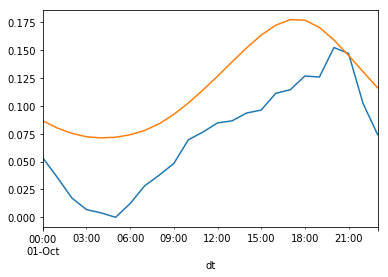

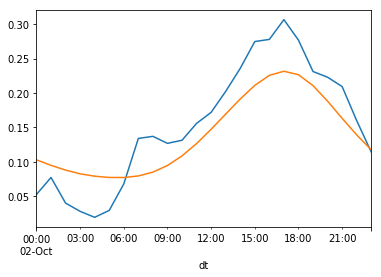

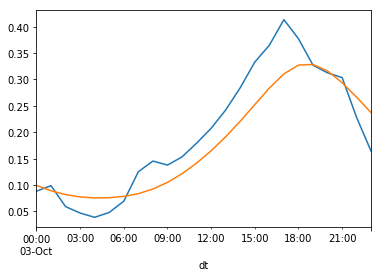

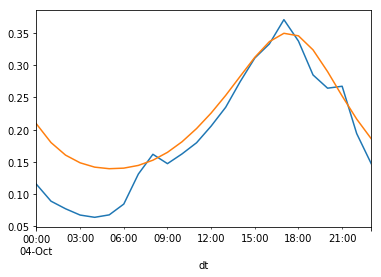

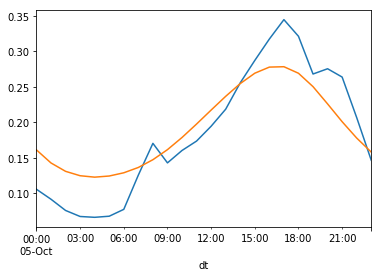

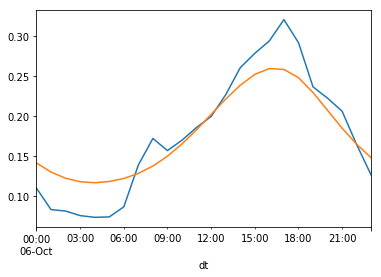

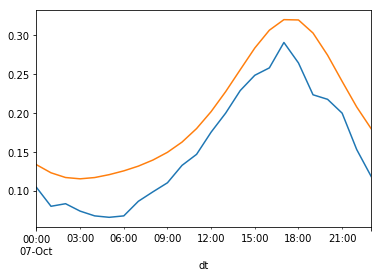

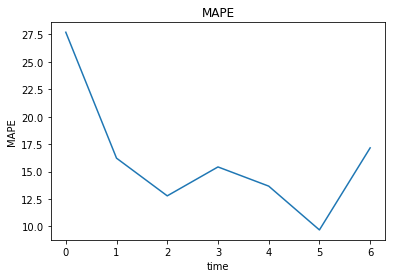

In [22]:
MAPEs=[]
for day in create_date_range('2017-10-01','2017-10-07'):
    results, rmse = predict_day(day,model,lookback)
    plt.figure()
    results.DAENERGY.plot()
    results.forecast.plot()
    y_pred = list_scalers['DAENERGY'].inverse_transform(results.forecast.values.reshape(-1,1))
    y_true = list_scalers['DAENERGY'].inverse_transform(results.DAENERGY.values.reshape(-1,1))
    MAPEs.append(MAPE(y_true, y_pred))
plt.figure()
plt.plot(MAPEs)
plt.title('MAPE')
plt.xlabel('time')
plt.ylabel('MAPE')
print('MAPE mean:{:.2f}'.format(np.array(MAPEs).mean()))

In [54]:
df

REGION,TRADEDATE,HOUROFWEEK,CYWG,K2G4,KABE,KABI,KACT,KACY,KADS,KAKR,...,KVCT,KWRI,KYNG,KZZV,LOAD,DAENERGY,RTENERGY,ISOWIND,OUTAGE,hourofday
dt,,,,,,,,,,,,,,,,,,,,,
2017-07-05 01:00:00,0.000000,0.431138,0.646154,0.634615,0.500000,0.656250,0.705882,0.517241,0.666667,0.607143,...,0.666667,0.491525,0.611111,0.633333,0.372750,0.104037,0.044699,0.308375,0.092918,0.043478
2017-07-05 02:00:00,0.000000,0.437126,0.584615,0.615385,0.517241,0.718750,0.720588,0.500000,0.727273,0.500000,...,0.651515,0.508475,0.481481,0.566667,0.224630,0.077516,0.039790,0.192283,0.064306,0.086957
2017-07-05 03:00:00,0.000000,0.443114,0.569231,0.615385,0.500000,0.703125,0.691176,0.500000,0.696970,0.482143,...,0.636364,0.508475,0.481481,0.550000,0.180757,0.070203,0.038474,0.180788,0.064306,0.130435
2017-07-05 04:00:00,0.000000,0.449102,0.553846,0.615385,0.500000,0.671875,0.661765,0.500000,0.666667,0.464286,...,0.621212,0.491525,0.462963,0.533333,0.157194,0.063573,0.037723,0.161814,0.064306,0.173913
2017-07-05 05:00:00,0.000000,0.455090,0.523077,0.596154,0.500000,0.625000,0.647059,0.482759,0.666667,0.446429,...,0.606061,0.491525,0.444444,0.533333,0.153534,0.061135,0.036666,0.161430,0.064306,0.217391
2017-07-05 06:00:00,0.000000,0.461078,0.523077,0.615385,0.534483,0.609375,0.632353,0.517241,0.651515,0.482143,...,0.590909,0.525424,0.481481,0.533333,0.185521,0.068058,0.037511,0.158961,0.064306,0.260870
2017-07-05 07:00:00,0.000000,0.467066,0.553846,0.653846,0.568966,0.609375,0.632353,0.568966,0.636364,0.535714,...,0.606061,0.559322,0.537037,0.583333,0.236064,0.081123,0.039085,0.139979,0.064306,0.304348
2017-07-05 08:00:00,0.000000,0.473054,0.584615,0.692308,0.620690,0.609375,0.661765,0.620690,0.651515,0.625000,...,0.681818,0.610169,0.611111,0.650000,0.314993,0.096236,0.042420,0.100705,0.064306,0.347826
2017-07-05 09:00:00,0.000000,0.479042,0.646154,0.711538,0.672414,0.671875,0.705882,0.637931,0.681818,0.714286,...,0.757576,0.644068,0.703704,0.733333,0.398355,0.118077,0.046178,0.064853,0.064306,0.391304


In [63]:
pd.Series.rolling(df['2017-10-01'].iloc[0:3].DAENERGY, window=3, center=False).mean()

dt
2017-10-01 00:00:00         NaN
2017-10-01 01:00:00         NaN
2017-10-01 02:00:00    0.035426
Name: DAENERGY, dtype: float64

In [58]:
df['2017-10-01'].DAENERGY

dt
2017-10-01 00:00:00    0.053335
2017-10-01 01:00:00    0.035686
2017-10-01 02:00:00    0.017258
2017-10-01 03:00:00    0.006923
2017-10-01 04:00:00    0.003998
2017-10-01 05:00:00    0.000000
2017-10-01 06:00:00    0.012383
2017-10-01 07:00:00    0.028276
2017-10-01 08:00:00    0.037832
2017-10-01 09:00:00    0.048264
2017-10-01 10:00:00    0.069520
2017-10-01 11:00:00    0.076443
2017-10-01 12:00:00    0.084633
2017-10-01 13:00:00    0.086486
2017-10-01 14:00:00    0.093506
2017-10-01 15:00:00    0.096139
2017-10-01 16:00:00    0.111154
2017-10-01 17:00:00    0.114372
2017-10-01 18:00:00    0.126658
2017-10-01 19:00:00    0.125780
2017-10-01 20:00:00    0.152204
2017-10-01 21:00:00    0.146938
2017-10-01 22:00:00    0.102087
2017-10-01 23:00:00    0.074103
Name: DAENERGY, dtype: float64

In [71]:
X.shape

(960, 49, 139)

In [155]:
df.head()

REGION,TRADEDATE,HOUROFWEEK,CYWG,K2G4,KABE,KABI,KACT,KACY,KADS,KAKR,...,ISOWIND,OUTAGE,hourofday,mean_3,mean_6,mean_9,mean_12,mean_24,p_24,p_48
dt,,,,,,,,,,,,,,,,,,,,,
2017-07-07 01:00:00,0.0,0.718563,0.553846,0.653846,0.586207,0.671875,0.705882,0.586207,0.727273,0.589286,...,0.096680,0.041076,0.043478,0.135943,0.209770,0.328490,0.391632,0.385350,0.105109,0.104037
2017-07-07 02:00:00,0.0,0.724551,0.492308,0.634615,0.517241,0.640625,0.676471,0.551724,0.681818,0.589286,...,0.520289,0.067422,0.086957,0.109528,0.169815,0.278564,0.366548,0.386181,0.083463,0.077516
2017-07-07 03:00:00,0.0,0.730539,0.476923,0.634615,0.517241,0.625000,0.647059,0.551724,0.666667,0.571429,...,0.519557,0.067422,0.130435,0.090359,0.139609,0.225869,0.333135,0.386548,0.072835,0.070203
2017-07-07 04:00:00,0.0,0.736527,0.461538,0.615385,0.517241,0.609375,0.632353,0.551724,0.651515,0.571429,...,0.499483,0.067422,0.173913,0.076184,0.112945,0.181383,0.293728,0.386861,0.065815,0.063573
2017-07-07 05:00:00,0.0,0.742515,0.492308,0.634615,0.534483,0.593750,0.617647,0.551724,0.621212,0.571429,...,0.477174,0.067422,0.217391,0.068517,0.093222,0.146483,0.246529,0.387011,0.062207,0.061135


In [156]:
df

REGION,TRADEDATE,HOUROFWEEK,CYWG,K2G4,KABE,KABI,KACT,KACY,KADS,KAKR,...,ISOWIND,OUTAGE,hourofday,mean_3,mean_6,mean_9,mean_12,mean_24,p_24,p_48
dt,,,,,,,,,,,,,,,,,,,,,
2017-07-07 01:00:00,0.000000,0.718563,0.553846,0.653846,0.586207,0.671875,0.705882,0.586207,0.727273,0.589286,...,0.096680,0.041076,0.043478,0.135943,0.209770,0.328490,0.391632,0.385350,0.105109,0.104037
2017-07-07 02:00:00,0.000000,0.724551,0.492308,0.634615,0.517241,0.640625,0.676471,0.551724,0.681818,0.589286,...,0.520289,0.067422,0.086957,0.109528,0.169815,0.278564,0.366548,0.386181,0.083463,0.077516
2017-07-07 03:00:00,0.000000,0.730539,0.476923,0.634615,0.517241,0.625000,0.647059,0.551724,0.666667,0.571429,...,0.519557,0.067422,0.130435,0.090359,0.139609,0.225869,0.333135,0.386548,0.072835,0.070203
2017-07-07 04:00:00,0.000000,0.736527,0.461538,0.615385,0.517241,0.609375,0.632353,0.551724,0.651515,0.571429,...,0.499483,0.067422,0.173913,0.076184,0.112945,0.181383,0.293728,0.386861,0.065815,0.063573
2017-07-07 05:00:00,0.000000,0.742515,0.492308,0.634615,0.534483,0.593750,0.617647,0.551724,0.621212,0.571429,...,0.477174,0.067422,0.217391,0.068517,0.093222,0.146483,0.246529,0.387011,0.062207,0.061135
2017-07-07 06:00:00,0.000000,0.748503,0.492308,0.615385,0.551724,0.578125,0.602941,0.568966,0.621212,0.589286,...,0.442102,0.067422,0.260870,0.066512,0.080969,0.121824,0.199160,0.386902,0.067278,0.068058
2017-07-07 07:00:00,0.000000,0.754491,0.523077,0.634615,0.551724,0.578125,0.617647,0.586207,0.636364,0.642857,...,0.395452,0.067422,0.304348,0.071929,0.075901,0.103325,0.162029,0.386861,0.080831,0.081123
2017-07-07 08:00:00,0.000000,0.760479,0.553846,0.653846,0.551724,0.625000,0.661765,0.620690,0.666667,0.714286,...,0.343386,0.067422,0.347826,0.082164,0.077387,0.092476,0.135304,0.386072,0.090581,0.096236
2017-07-07 09:00:00,0.000000,0.766467,0.600000,0.673077,0.568966,0.703125,0.735294,0.655172,0.727273,0.767857,...,0.279632,0.067422,0.391304,0.100102,0.086607,0.091004,0.120726,0.385922,0.117005,0.118077


In [24]:
df.shape

(4056, 150)